Danish art 'motivs' from Wikidata
==================

'Motivs' (depictions) in Danish artworks present in Wikidata.

In [1]:
import pandas as pd
import sparql
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Formulation of a query to Wikidata 
service = sparql.Service("https://query.wikidata.org/sparql", method="GET")
statement = """
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX wd: <http://www.wikidata.org/entity/> 
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX v: <http://www.wikidata.org/prop/statement/>

SELECT ?artwork ?artworkLabel ?motiv ?motivLabel ?filename WHERE {
   ?artwork wdt:P31 wd:Q3305213 .
   ?artwork wdt:P180 ?motiv .        
   ?artwork wdt:P195 ?collection .
   ?collection wdt:P17 wd:Q35 .

   OPTIONAL {?artwork wdt:P18 ?filename } 

   SERVICE wikibase:label {
     bd:serviceParam wikibase:language "da,en" .
   } 
 }
"""

In [3]:
# Querying Wikidata and formatting it for a DataFrame
result = service.query(statement)
df = pd.DataFrame(result.fetchall(), columns=result.variables)

In [4]:
df.shape

(2433, 5)

In [5]:
# Show a bit of the download data
df.head()

,artwork,artworkLabel,motiv,motivLabel,filename
0,http://www.wikidata.org/entity/Q12332504,Præsentation for en kender,http://www.wikidata.org/entity/Q1259917,violinist,http://commons.wikimedia.org/wiki/Special:File...
1,http://www.wikidata.org/entity/Q20010686,Skagensjægere,http://www.wikidata.org/entity/Q25391,klit,http://commons.wikimedia.org/wiki/Special:File...
2,http://www.wikidata.org/entity/Q20010686,Skagensjægere,http://www.wikidata.org/entity/Q38774,jagthund,http://commons.wikimedia.org/wiki/Special:File...
3,http://www.wikidata.org/entity/Q20010686,Skagensjægere,http://www.wikidata.org/entity/Q468252,Michael Ancher,http://commons.wikimedia.org/wiki/Special:File...
4,http://www.wikidata.org/entity/Q20010686,Skagensjægere,http://www.wikidata.org/entity/Q6051740,Ulrik Plesner,http://commons.wikimedia.org/wiki/Special:File...


In [6]:
# Set up feature matrix
motivs = set([item.value for item in df['motivLabel']])
artworks = set([item.value for item in df['artwork']])
feature_matrix = pd.DataFrame(0, index=artworks, columns=motivs)
artwork_mapper = {}
filename_mapper = {}
for n, row in df.iterrows():
    artwork = row['artwork'].value
    motiv = row['motivLabel'].value
    feature_matrix.ix[artwork, motiv] = 1 
    artwork_mapper[artwork] = row['artworkLabel'].value
    filename_mapper[artwork] = str(row['filename'])[51:]

In [7]:
feature_matrix.shape

(571, 896)

In [8]:
# Show a bit of the constructed feature matrix
feature_matrix.head()

,Ernst Meyer,papegøje,Ambolt,trappe,HMS Shannon,Capri,stynede træer,gang,ørering,skib,...,København,bænk,Dollerup Bakker,Søndagsskole,fest,Alkyone,foredrag,terrasse,dysse,skygge
http://www.wikidata.org/entity/Q22340518,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
http://www.wikidata.org/entity/Q20532767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
http://www.wikidata.org/entity/Q20540698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
http://www.wikidata.org/entity/Q20540929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
http://www.wikidata.org/entity/Q20355485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Some arbitrary scaling - more research needed here
scaled_feature_matrix = feature_matrix.copy()
scaled_feature_matrix = scaled_feature_matrix.divide((feature_matrix.sum(axis=1)) ** 0.9, axis='index')
scaled_feature_matrix = scaled_feature_matrix.divide((feature_matrix.sum(axis=0)) ** 0.05, axis='columns')

In [10]:
# Machine learning decomposition with non-negative matrix factorization
from sklearn.decomposition import NMF
decomposer = NMF(n_components=12)
decomposer.fit(scaled_feature_matrix)
transformed = decomposer.transform(scaled_feature_matrix)

In [11]:
# Show the results
for topic_id in range(decomposer.components_.shape[0]):
    indices = (-decomposer.components_[topic_id, :]).argsort()[:10]
    s = ""
    for index in indices:
        s += "%s (%f) " %  (scaled_feature_matrix.columns[index], 
                            decomposer.components_[topic_id, index])
    print(s + '\n')

kvinde (2.813067) nøgenhed (0.109899) tørklæde (0.076774) ager (0.076171) have (0.075465) bord (0.069592) læsning (0.069085) Anna Dorothea Therbusch (0.065968) Dianthus caryophyllus (0.065968) Susanna (0.065571) 

mand (1.714280) Ferdinand Meldahl (0.100443) Baret (0.073555) skæg (0.070825) fisker (0.065111) bog (0.059392) barn (0.052029) N.F.S. Grundtvig (0.051175) Fritz Melbye (0.050317) Henri Matisse (0.050317) 

himmel (1.264783) sky (0.880521) sejlskib (0.219555) strand (0.131058) vej (0.121052) hav (0.112295) solnedgang (0.089970) kyst (0.075524) gravhøj (0.073034) Fyrreslægten (0.072058) 

træ (1.678035) kirke (0.433185) hus (0.190315) sne (0.147630) gruppe af mennesker (0.121422) Laterankirken (0.107985) tamkvæg (0.089141) vinter (0.083785) gadekær (0.080518) himmel (0.079368) 

pige (1.388884) syning (0.373608) Almindelig Solsikke (0.139515) Girl in a Picture Frame (0.139515) kjole (0.134202) vindue (0.074492) spejl (0.072843) Pile-slægten (0.066965) stær (0.066965) seng (0.06

In [12]:
topic_ids = transformed.shape[1]
for topic_id in range(topic_ids):
    print('\nTopic %d' % (topic_id + 1,))
    indices = (-decomposer.components_[topic_id, :]).argsort()[:5]
    s = ""
    for index in indices:
        s += "%s (%f) " %  (scaled_feature_matrix.columns[index], 
                            decomposer.components_[topic_id, index])
    print(s + '\n')
    indices = (-transformed[:, topic_id]).argsort()[:20]
    for index in indices:
        print("%f %s" % (transformed[index, topic_id], artwork_mapper[feature_matrix.index[index]]))



Topic 1
kvinde (2.813067) nøgenhed (0.109899) tørklæde (0.076774) ager (0.076171) have (0.075465) 

0.277335 Dame ved sit toilette
0.277335 Prinsesse Wilhelmine, Frederik VI's datter
0.277335 Modellen Stella i Rom
0.277335 Portræt af lensgrevinde Lillie Suzanne Raben-Levetzau
0.277335 Olga Buhre
0.277335 En gammel kone
0.277335 Portrait of a 39-year-old Woman
0.153410 Portræt af gammel bondekone
0.153161 Et hjørne af haven i Éragny. Kunstnerens hjem
0.153074 Kartoffelgravning
0.153031 Kvinde med nellike
0.153031 Selvportræt
0.152918 Læsende dame
0.152756 Susanna. Skitse
0.152710 En ung pige, der plukker en svane
0.152539 Cathrine Jensen, f. Lorenzen, kunstnerens hustru med turban
0.152396 Tahitian Woman with a Flower
0.150653 Skuespillerinden Johanne Cathrine Rosing
0.149607 Portræt af en ung pige. Kunstnerens søster, Anna Hammershøi
0.148258 Skovlandskab. Forår

Topic 2
mand (1.714280) Ferdinand Meldahl (0.100443) Baret (0.073555) skæg (0.070825) fisker (0.065111) 

0.448276 Studie a

In [13]:
# Write part of an HTML file with image grouped accoring to topic
with open('tmp.html', 'w') as f:
    topic_ids = transformed.shape[1]
    for topic_id in range(topic_ids):
        f.write('<h3>Emne %d</h3>\n' % (topic_id + 1,))
        indices = (-decomposer.components_[topic_id, :]).argsort()[:5]
        s = ""
        for index in indices:
            if decomposer.components_[topic_id, index] < 0.0001:
                break
            s += "%s. " %  (scaled_feature_matrix.columns[index],)
        f.write('Motiver: ' + s.encode('utf-8') + '<br/>\n')
        indices = (-transformed[:, topic_id]).argsort()[:15]
        for index in indices:
            if transformed[index, topic_id] < 0.0001:
                break
            qid = int(feature_matrix.index[index][32:])
            filename = filename_mapper[feature_matrix.index[index]]
            if filename:
                f.write("<a href='http://wikidata.org/wiki/Q%d'><img src='https://commons.wikimedia.org/w/thumb.php?f=%s&width=200'></a>\n" % (qid, filename,))


In [14]:
# Graph with 'motivs' as nodes
graph = nx.Graph()
for motiv in feature_matrix.columns:
    graph.add_node(motiv)
    
for image, row in feature_matrix.iterrows():
    motivs = row.index[row.nonzero()[0]].tolist()
    for i1 in range(len(motivs) - 1):
        for i2 in range(i1 + 1, len(motivs)):
            graph.add_edge(motivs[i1], motivs[i2])

In [15]:
subgraph = next(nx.connected_component_subgraphs(graph))

In [16]:
# Good position layout is always a problem - here default spring layout is attempted
# pos = nx.layout.spectral_layout(graph)
pos = nx.layout.spring_layout(subgraph, iterations=50)

In [17]:
# Plotting the motiv graph
node_sizes = 50 * feature_matrix.sum(axis=0)[subgraph.nodes()]
nx.draw_networkx_nodes(subgraph, pos=pos, node_size=node_sizes, node_color='r', alpha=0.5, linewidths=0)
nx.draw_networkx_edges(subgraph, nodelist=subgraph.nodes(), pos=pos, alpha=0.05, color='r', linewidths=3)

positions = [pos[node] for node in subgraph.nodes()]
for i in np.argsort(node_sizes)[:-31:-1]:
    plt.text(positions[i][0], positions[i][1], subgraph.nodes()[i], 
             horizontalalignment='center', verticalalignment='center')

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_position([0, 0, 1, 1])
ax.axis([-0.05, 1.05, -0.05, 1.05])
ax.axis([0.3, 0.7, 0.3, 0.7])

plt.text(0.5, 0.65, u'Motiver i danske kunstværker i Wikidata',
         fontsize=50,
         backgroundcolor=(1, 1, 1),
         horizontalalignment='center', verticalalignment='center')

In [18]:
# Save the image in a file
plt.gcf().set_size_inches(18, 12, forward=True)
plt.savefig('Danish art motivs from Wikidata.png')

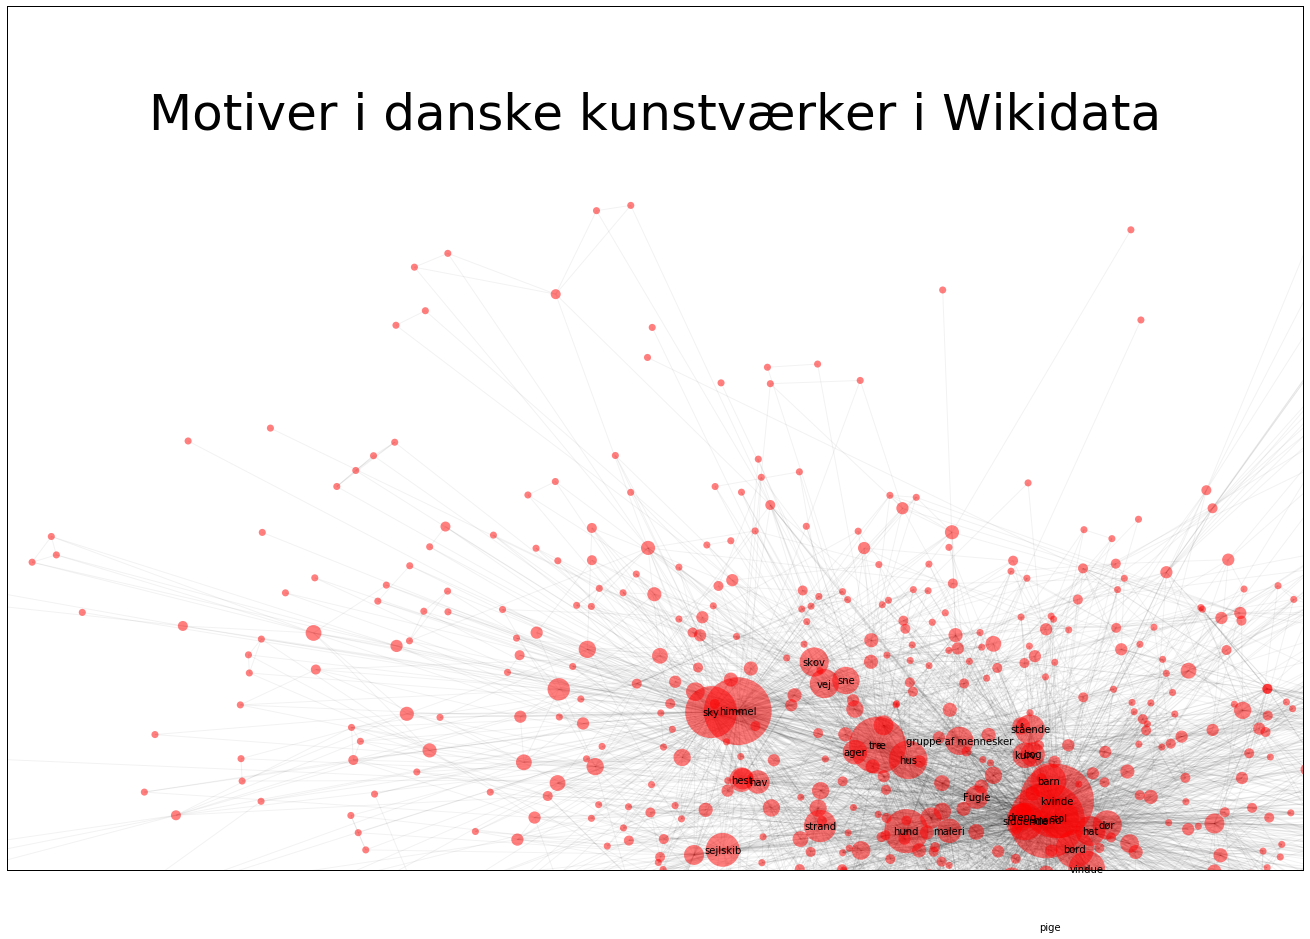

In [19]:
plt.show()